In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmf import MassFunction
from astropy.cosmology import Planck15 as cosmo
from astropy import coordinates, cosmology, units
from scipy.integrate import simpson
from math import atan, cos, pi
import random
from scipy import interpolate
import pandas as pd
from astropy.table import Table
import warnings
from tqdm import tqdm
from scipy.integrate import quad
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib
from matplotlib.ticker import MultipleLocator

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'
sns.set_context('talk') 
sns.set(font_scale=1.4)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']

cmap = matplotlib.cm.get_cmap('magma_r')
colors = ["white", "white", "white"]+[cmap(i/100) for i in range(100)]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                           colors)


In [2]:
def xi(r, r0, gamma=1.85):
    """
    Calculate the power-law correlation function.

    Parameters:
    - r: Distance(s) at which to evaluate the correlation function
    - r0: Scaling parameter
    - gamma: Power-law index (default is 1.85)

    Returns:
    - Correlation function value(s) evaluated at r
    """
    return (r / r0) ** -gamma


import numpy as np

def effective_number_density_factor(z, r0_0, q, gamma, Dmin, Dmax):
    """
    Calculate the effective number density factor for a given range of distances.

    Parameters:
    - z: Redshift or array of redshifts
    - r0_0: Correlation length or scaling parameter at z=0
    - q: A parameter influencing the factor calculation
    - gamma: Power-law exponent
    - Dmin: Minimum distance or array of minimum distances
    - Dmax: Maximum distance or array of maximum distances

    Returns:
    - Factor: Effective number density factor computed based on the input parameters
    """
    factor = 1 + ((3*(r0_0**gamma) * (np.array(Dmax)**-gamma))/(3-gamma))
    return factor



# https://iopscience.iop.org/article/10.1088/0004-637X/767/2/122; Peebles 1980
r0_0 = 5.4/cosmo.h # Mpc
q = -2.28
gamma = 1.85

In [3]:
redshift_array = np.linspace(0, 2, 1000)
mass_funcs = []

logm = np.linspace(5, 12, 100)
for redshift_slice_idx in tqdm(range(len(redshift_array)-1)):
    z_slice = (redshift_array[redshift_slice_idx]+redshift_array[redshift_slice_idx+1])/2
    phi, _, _ = generate_phi(z_slice, 5)
    mass_funcs.append(phi)
    

100%|████████████████████████████████████████████████████████████| 999/999 [00:18<00:00, 55.38it/s]


In [4]:
effective_n_wo_clustering = []
effective_N_wo_clustering = []
effective_N_clustering = []
mean_redshifts = []

deltas = []

for redshift_slice_idx in tqdm(range(len(redshift_array)-1)):
    z_slice = (redshift_array[redshift_slice_idx]+redshift_array[redshift_slice_idx+1])/2
    mean_redshifts.append(z_slice)
    
    omega = ((np.pi*((3*2)*np.pi/(3600*180))**2) * ((cosmo.angular_diameter_distance(z_slice).value/cosmo.comoving_distance(z_slice).value)**2))/(4*np.pi)
    V_shell = (4*np.pi/3)*(cosmo.comoving_distance(redshift_array[redshift_slice_idx+1]).value**3-cosmo.comoving_distance(redshift_array[redshift_slice_idx]).value**3)*omega # Mpc^3
    
    n_wo_clustering = simpson(mass_funcs[redshift_slice_idx], logm) # counts/Mpc^3
    effective_n_wo_clustering.append(n_wo_clustering)
    effective_N_wo_clustering.append(V_shell * n_wo_clustering)

    delta = cosmo.comoving_distance(redshift_array[redshift_slice_idx+1]).value-cosmo.comoving_distance(redshift_array[redshift_slice_idx]).value
    deltas.append(delta)
    
    factor = effective_number_density_factor(z_slice, r0_0, q, gamma, 0, delta)
    effective_N_clustering.append(effective_N_wo_clustering[-1]*factor)



100%|██████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1097.51it/s]


In [5]:
data = np.load('frbs_data/p_of_dm_z.npy')
zgrid, dmgrid, probability = data[0], data[1], data[2]
N = 10000
DMexgals = np.linspace(0, 1000, 11)
probs_mean, probs_errl, probs_erru = [], [], []

z_lims = []
probabilities_sim1 = []
for j in tqdm(range(len(DMexgals))):
    DMexgal = DMexgals[j]
    zs = np.array(zgrid[np.where(np.abs(dmgrid-DMexgal) == np.min(np.abs(dmgrid-DMexgal)))])
    ps = np.array(probability[np.where(np.abs(dmgrid-DMexgal) == np.min(np.abs(dmgrid-DMexgal)))])
    fxn = interpolate.interp1d(zs, ps, bounds_error=False, fill_value="extrapolate")
    probs = fxn(mean_redshifts)/sum(fxn(mean_redshifts))
    
    cts_mean = sum(effective_N_clustering*probs)
    cts_sample = np.random.poisson(cts_mean, (N, N))
    probabilities_sim1.append(np.sum(cts_sample>1, axis=0)/N)
    probs_mean.append(print_sigmas(probabilities_sim1[-1], 1)[0])
    probs_errl.append(print_sigmas(probabilities_sim1[-1], 1)[1])
    probs_erru.append(print_sigmas(probabilities_sim1[-1], 1)[2])
    
    

100%|██████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.69s/it]


In [6]:
redshift_array = np.linspace(0, 2, 1000)

effective_N_clusterings = []

for i in tqdm(range(100)):
    effective_N_clustering = []
    for redshift_slice_idx in (range(len(redshift_array)-1)):
        z_slice = (redshift_array[redshift_slice_idx]+redshift_array[redshift_slice_idx+1])/2
        
        omega = ((np.pi*((3*2)*np.pi/(3600*180))**2) * ((cosmo.angular_diameter_distance(z_slice).value/cosmo.comoving_distance(z_slice).value)**2))/(4*np.pi)
        V_shell = (4*np.pi/3)*(cosmo.comoving_distance(redshift_array[redshift_slice_idx+1]).value**3-cosmo.comoving_distance(redshift_array[redshift_slice_idx]).value**3)*omega # Mpc^3
        
        n_wo_clustering = simpson(generate_phi(z_slice)[0], logm) # counts/Mpc^3
    
        delta = cosmo.comoving_distance(redshift_array[redshift_slice_idx+1]).value-cosmo.comoving_distance(redshift_array[redshift_slice_idx]).value
        factor = effective_number_density_factor(z_slice, r0_0, q, gamma, 0, delta)
        effective_N_clustering.append(V_shell * n_wo_clustering * factor)
    effective_N_clusterings.append(effective_N_clustering)


100%|████████████████████████████████████████████████████████████| 100/100 [30:51<00:00, 18.51s/it]


In [7]:
N = 10000
probs_mean_, probs_errl_, probs_erru_ = [], [], []

probabilities_sim1 = []
for j in tqdm(range(len(DMexgals))):
    DMexgal = DMexgals[j]
    zs = np.array(zgrid[np.where(np.abs(dmgrid-DMexgal) == np.min(np.abs(dmgrid-DMexgal)))])
    ps = np.array(probability[np.where(np.abs(dmgrid-DMexgal) == np.min(np.abs(dmgrid-DMexgal)))])
    fxn = interpolate.interp1d(zs, ps, bounds_error=False, fill_value="extrapolate")
    probs = fxn(mean_redshifts)/sum(fxn(mean_redshifts))
    probs = np.abs(probs)/sum(probs)
    
    samps = np.random.choice(mean_redshifts, size=N, p=probs/np.sum(probs), replace=True)
    z_max = np.percentile(samps, 95)
    dz = mean_redshifts[1]-mean_redshifts[0]
    mask = mean_redshifts<z_max
    probs = mask*dz 
    
    cts_mean = sum(effective_N_clustering*probs)
    cts_sample = np.random.poisson(cts_mean, (N, N))
    probabilities_sim1.append(np.sum(cts_sample>1, axis=0)/N)
    probs_mean_.append(print_sigmas(probabilities_sim1[-1], 1)[0])
    probs_errl_.append(print_sigmas(probabilities_sim1[-1], 1)[1])
    probs_erru_.append(print_sigmas(probabilities_sim1[-1], 1)[2])
    
    

100%|██████████████████████████████████████████████████████████████| 11/11 [00:35<00:00,  3.24s/it]


Text(0.01, 1.055, 'c')

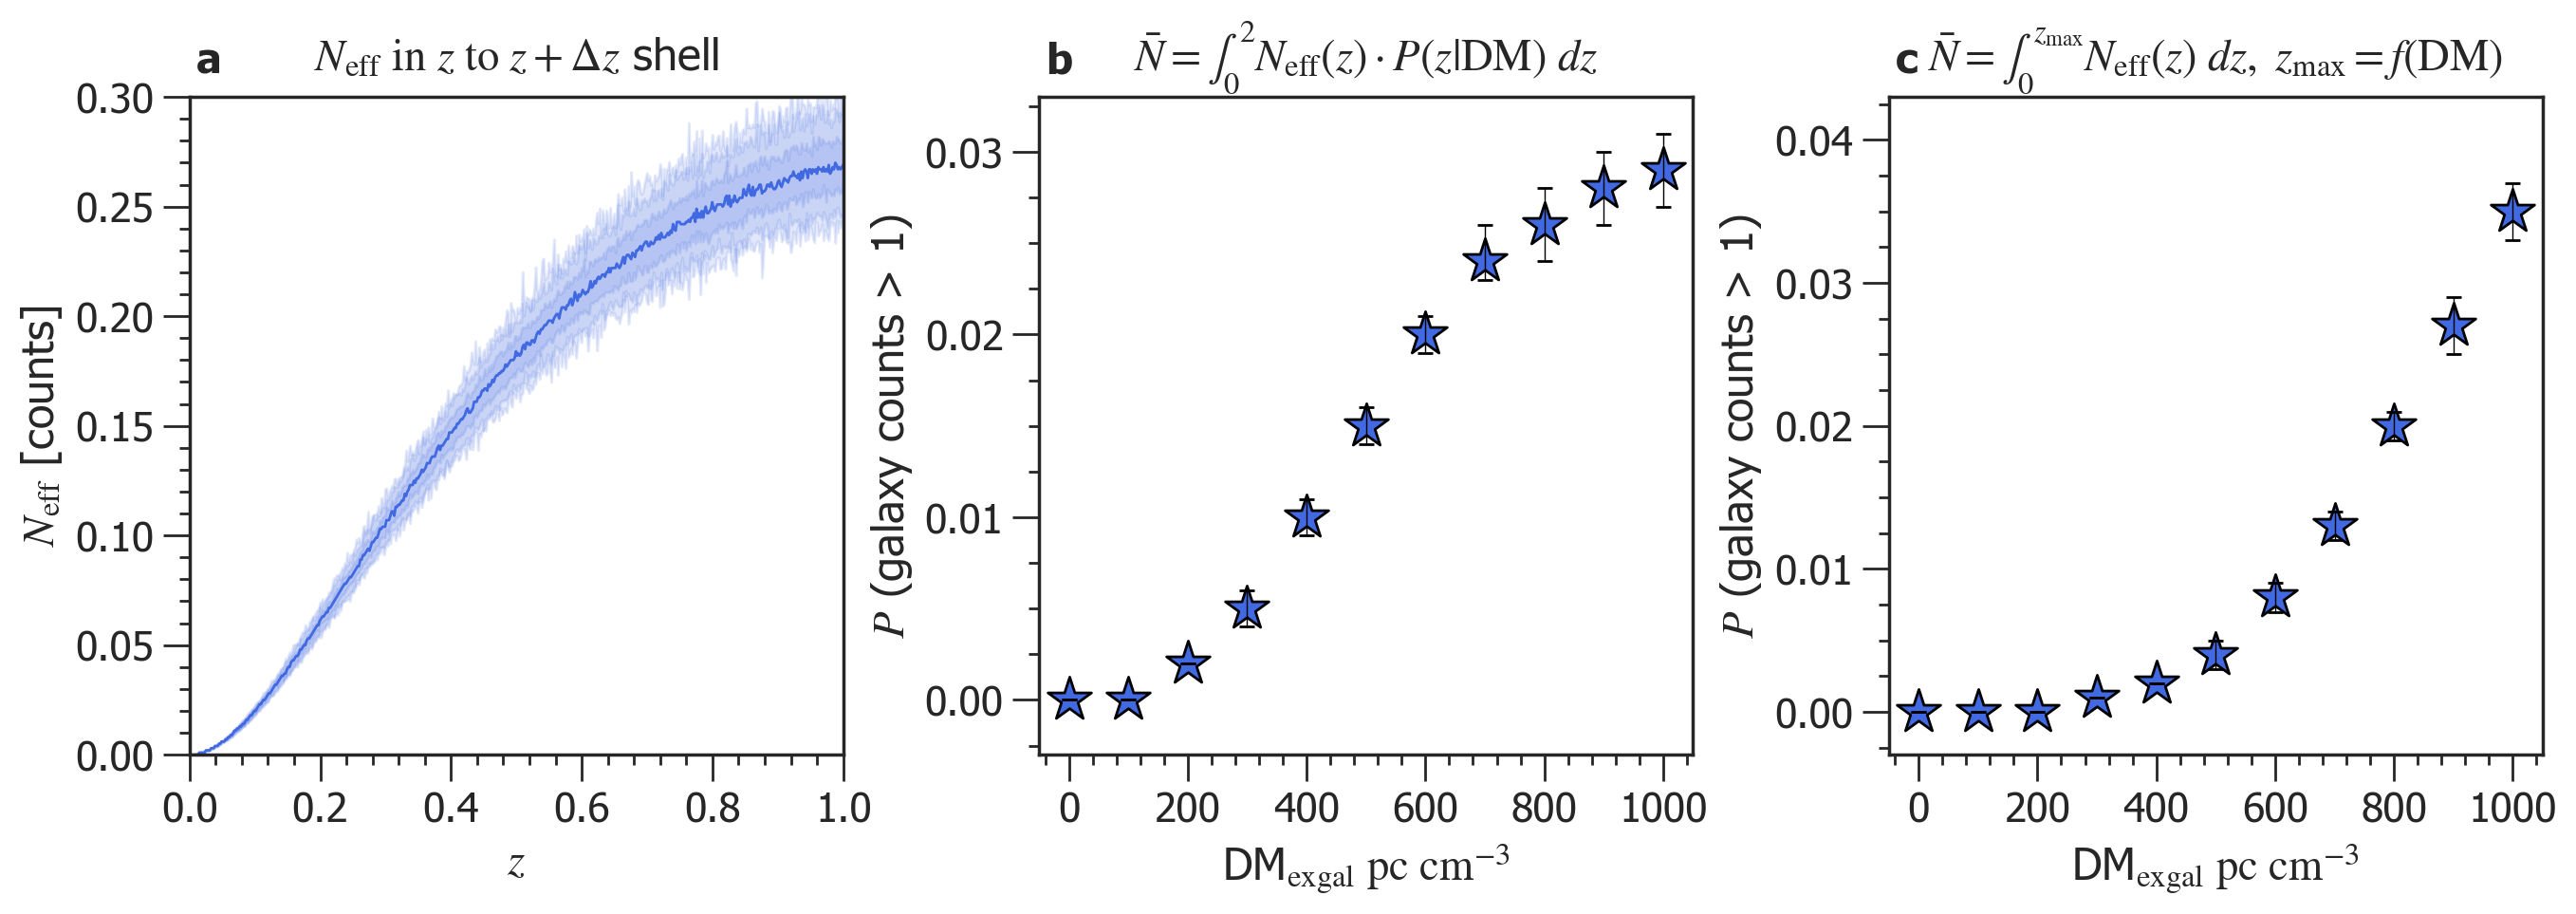

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4.5))

quant16, quant50, quant84 = return_quants_single(effective_N_clusterings, sigma=1)
ax1.plot(mean_redshifts, quant50, color = 'royalblue', lw=1)
ax1.fill_between(mean_redshifts, np.array(quant50)+np.array(quant16), np.array(quant50)+np.array(quant84), 
                 color="royalblue", alpha=0.15)
quant16, quant50, quant84 = return_quants_single(effective_N_clusterings, sigma=2)
ax1.fill_between(mean_redshifts, np.array(quant50)+np.array(quant16), np.array(quant50)+np.array(quant84), 
                 color="royalblue", alpha=0.15)
quant16, quant50, quant84 = return_quants_single(effective_N_clusterings, sigma=3)
ax1.fill_between(mean_redshifts, np.array(quant50)+np.array(quant16), np.array(quant50)+np.array(quant84), 
                 color="royalblue", alpha=0.15)
ax1.set_xlabel(r"$z$")
ax1.set_ylabel(r"$N_\mathrm{eff}$ [counts]")

ax1.set_xlim(0, 1)
ax1.set_xticks(np.arange(0, 1, 0.2))
ax1.xaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
ax1.xaxis.set_minor_locator(MultipleLocator(0.04)) 
ax1.set_ylim(0, 0.3)
ax1.set_yticks(np.arange(0, 0.3, 0.05))
ax1.yaxis.set_major_locator(MultipleLocator(0.05))                                                                                                                                                                                                                     
ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
ax1.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax1.tick_params(which='both', width=1)
ax1.tick_params(which='major', length=10)
ax1.tick_params(which='minor', length=4)

ax2.errorbar(DMexgals, probs_mean, yerr = [np.abs(probs_errl), probs_erru], 
             ecolor="black", fmt="*", capsize=3, elinewidth=0.5, markerfacecolor="none", markeredgecolor="none")
im = ax2.scatter(DMexgals, probs_mean, c = 'royalblue', marker="*", s=300, edgecolors='black')



ax2.set_xlabel(r"DM$_\mathrm{exgal}~\mathrm{pc~cm}^{-3}$")
ax2.set_ylabel(r"$P$ (galaxy counts > 1)")

ax2.set_xlim(-50, 1050)
ax2.set_xticks(np.arange(0, 1050, 200))
ax2.xaxis.set_major_locator(MultipleLocator(200))                                                                                                                                                                                                                     
ax2.xaxis.set_minor_locator(MultipleLocator(40)) 
ax2.set_ylim(-0.003, 0.033)
ax2.set_yticks(np.arange(0, 0.04, 0.01))
ax2.yaxis.set_major_locator(MultipleLocator(0.01))                                                                                                                                                                                                                     
ax2.yaxis.set_minor_locator(MultipleLocator(0.0025))
ax2.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax2.tick_params(which='both', width=1)
ax2.tick_params(which='major', length=10)
ax2.tick_params(which='minor', length=4)


ax3.errorbar(DMexgals, probs_mean_, yerr = [np.abs(probs_errl_), probs_erru_], 
             ecolor="black", fmt="*", capsize=3, elinewidth=0.5, markerfacecolor="none", markeredgecolor="none")
im = ax3.scatter(DMexgals, probs_mean_, c = 'royalblue', marker="*", s=300, edgecolors='black')



ax3.set_xlabel(r"DM$_\mathrm{exgal}~\mathrm{pc~cm}^{-3}$")
ax3.set_ylabel(r"$P$ (galaxy counts > 1)")

ax3.set_xlim(-50, 1050)
ax3.set_xticks(np.arange(0, 1050, 200))
ax3.xaxis.set_major_locator(MultipleLocator(200))                                                                                                                                                                                                                     
ax3.xaxis.set_minor_locator(MultipleLocator(40)) 
ax3.set_ylim(-0.003, 0.043)
ax3.set_yticks(np.arange(0, 0.04, 0.01))
ax3.yaxis.set_major_locator(MultipleLocator(0.01))                                                                                                                                                                                                                     
ax3.yaxis.set_minor_locator(MultipleLocator(0.0025))
ax3.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax3.tick_params(which='both', width=1)
ax3.tick_params(which='major', length=10)
ax3.tick_params(which='minor', length=4)

plt.subplots_adjust(wspace=0.3)

ax1.set_title(r'$N_\mathrm{eff}~\mathrm{in}~z~\mathrm{to}~z+\Delta z$ shell', pad=10)
ax2.set_title(r'$\bar{N} = \int_0^2 N_\mathrm{eff}(z) \cdot P(z|\mathrm{DM})~dz$', pad=10)
ax3.set_title(r'$\bar{N} = \int_0^{z_\mathrm{max}} N_\mathrm{eff}(z)~dz,~z_\mathrm{max} = f(\mathrm{DM})$', pad=10)

ax1.text(0.01, 1.055, "a", ha='left', va='center', weight='bold', 
         transform=ax1.transAxes, fontsize=16)
ax2.text(0.01, 1.055, "b", ha='left', va='center', weight='bold', 
         transform=ax2.transAxes, fontsize=16)
ax3.text(0.01, 1.055, "c", ha='left', va='center', weight='bold', 
         transform=ax3.transAxes, fontsize=16)

